# 1 Exploratory Data Analysis (EDA)

This notebook explores the Avocado dataset and computes industry-relevant KPIs.

**KPIs:**
- ASP (Average Selling Price)
- Total Volume
- Revenue (proxy): ASP × Total Volume
- Volume Growth %
- ASP Change %
- Market Share by region/type
- Seasonality Index (monthly)
- Exploratory Price Elasticity

> Charts use matplotlib only, one plot per figure, default styles.


In [11]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = os.path.join('..', 'data', 'avocado.csv')
df = pd.read_csv(DATA_PATH)

# Basic cleaning
df.columns = [c.strip().replace(' ', '_').lower() for c in df.columns]
# Expect typical columns: Date, AveragePrice, type, year, region, Total Volume, etc.
# Make sure date is datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
else:
    raise ValueError('Expected a "date" column in avocado.csv')

# Revenue proxy
if 'averageprice' in df.columns and 'total_volume' in df.columns:
    df['revenue_proxy'] = df['averageprice'] * df['total_volume']
else:
    raise ValueError('Expected "AveragePrice" and "Total Volume" columns (lowercased with underscores).')

# Basic info
print(df.head())
print(df.info())
print(df.describe(include='all'))


        date  averageprice  total_volume     4046       4225    4770  \
0 2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1 2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2 2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3 2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4 2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   total_bags  small_bags  large_bags  xlarge_bags          type  year  \
0     8696.87     8603.62       93.25          0.0  conventional  2015   
1     9505.56     9408.07       97.49          0.0  conventional  2015   
2     8145.35     8042.21      103.14          0.0  conventional  2015   
3     5811.16     5677.40      133.76          0.0  conventional  2015   
4     6183.95     5986.26      197.69          0.0  conventional  2015   

   region  revenue_proxy  
0  Albany     85434.7046  
1  Albany     74083.9230  
2  Albany    109944.8046  
3  Albany     

## KPI Tables

We compute key KPIs at national and regional levels and over time.


In [12]:

# National weekly KPIs
weekly_nat = (
    df.groupby('date', as_index=False)
      .agg(asp=('averageprice','mean'),
           total_volume=('total_volume','sum'),
           revenue_proxy=('revenue_proxy','sum'))
      .sort_values('date')
)
weekly_nat['volume_growth_pct'] = weekly_nat['total_volume'].pct_change()*100.0
weekly_nat['asp_change_pct'] = weekly_nat['asp'].pct_change()*100.0

# Market share by region/type (latest date or a selected date window)
latest_date = df['date'].max()
latest = df[df['date'] == latest_date].copy()
market_share = (
    latest.groupby(['region','type'], as_index=False)
          .agg(total_volume=('total_volume','sum'))
)
market_share['region_type_share_pct'] = 100 * market_share['total_volume'] / market_share['total_volume'].sum()

weekly_nat.head()


,date,asp,total_volume,revenue_proxy,volume_growth_pct,asp_change_pct
0,2015-01-04,1.301296,8.467434e+07,8.107588e+07,NaN,NaN
1,2015-01-11,1.370648,7.855581e+07,8.012434e+07,-7.225956,5.329444
2,2015-01-18,1.391111,7.838878e+07,8.188651e+07,-0.212617,1.492941
3,2015-01-25,1.397130,7.646628e+07,8.048259e+07,-2.452523,0.432641
4,2015-02-01,1.247037,1.194532e+08,1.078265e+08,56.216876,-10.742925


### Plot — ASP and Total Volume over time (National)


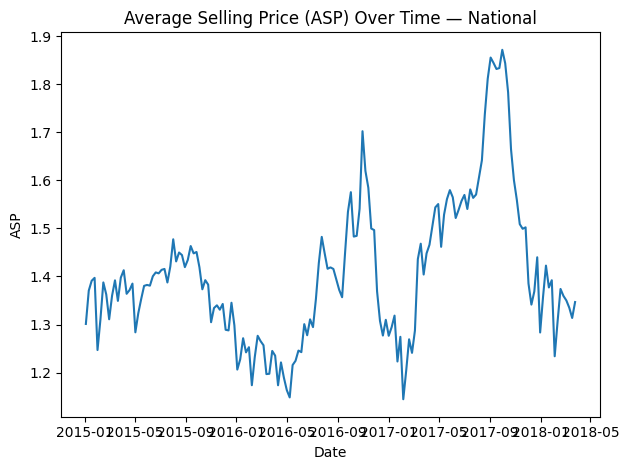

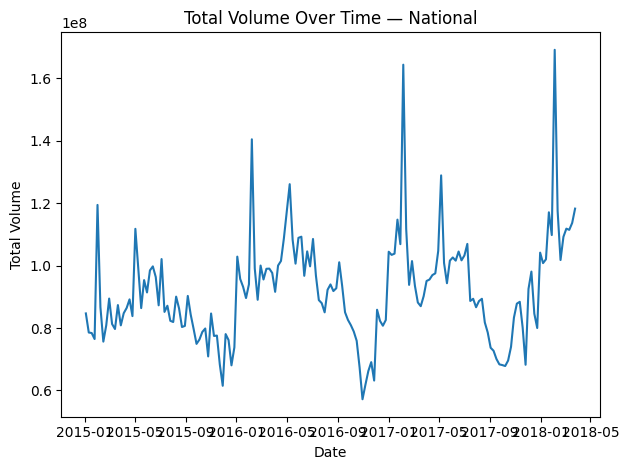

In [13]:

plt.figure()
plt.plot(weekly_nat['date'], weekly_nat['asp'])
plt.title('Average Selling Price (ASP) Over Time — National')
plt.xlabel('Date')
plt.ylabel('ASP')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(weekly_nat['date'], weekly_nat['total_volume'])
plt.title('Total Volume Over Time — National')
plt.xlabel('Date')
plt.ylabel('Total Volume')
plt.tight_layout()
plt.show()


## Regional KPIs & Organic vs Conventional


In [14]:

regional_kpis = (
    df.groupby(['region','type'], as_index=False)
      .agg(mean_asp=('averageprice','mean'),
           median_asp=('averageprice','median'),
           total_volume=('total_volume','sum'),
           revenue_proxy=('revenue_proxy','sum'))
)
regional_kpis.sort_values(['region','type']).head(10)


,region,type,mean_asp,median_asp,total_volume,revenue_proxy
0,Albany,conventional,1.348757,1.35,1.570061e+07,2.113653e+07
1,Albany,organic,1.773314,1.82,3.671885e+05,6.301913e+05
2,Atlanta,conventional,1.068817,1.06,8.666139e+07,9.081974e+07
3,Atlanta,organic,1.607101,1.62,1.943727e+06,2.973630e+06
4,BaltimoreWashington,conventional,1.344201,1.29,1.307456e+08,1.732252e+08
5,BaltimoreWashington,organic,1.724260,1.69,3.968344e+06,6.683217e+06
6,Boise,conventional,1.076036,1.06,1.400054e+07,1.473256e+07
7,Boise,organic,1.620237,1.56,4.126472e+05,6.141053e+05
8,Boston,conventional,1.304379,1.27,9.490044e+07,1.223635e+08
9,Boston,organic,1.757396,1.82,2.373547e+06,4.179383e+06


### Plot — Organic vs Conventional ASP by Region (Top 15 by volume)


type           conventional   organic
region                               
California         1.105444  1.685207
DallasFtWorth      0.846450  1.324734
GreatLakes         1.181893  1.495207
Houston            0.825089  1.270769
LosAngeles         0.976450  1.455562


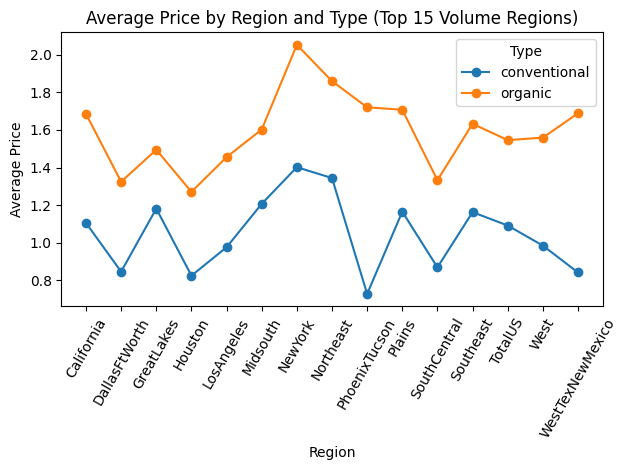

In [22]:

top_regions = (df.groupby('region', as_index=False)['total_volume'].sum()
                 .sort_values('total_volume', ascending=False)
                 .head(15)['region'].tolist())

asp_by_region_type = (df[df['region'].isin(top_regions)]
                      .groupby(['region','type'], as_index=False)['averageprice'].mean())

# Pivot for display
pivot = asp_by_region_type.pivot(index='region', columns='type', values='averageprice').fillna(0)
print(pivot.head())

plt.figure()
for t in pivot.columns:
    plt.plot(pivot.index, pivot[t], marker='o', label = t)
plt.title('Average Price by Region and Type (Top 15 Volume Regions)')
plt.xlabel('Region')
plt.ylabel('Average Price')
plt.xticks(rotation=60)
plt.legend(title="Type") 
plt.tight_layout()
plt.show()


## Seasonality Index (Monthly)


Seasonality Index (ASP):
[0.92754139 0.90162441 0.94256607 0.97236968 0.95271555 0.99683782
 1.03441458 1.07009897 1.11264788 1.11762032 1.02980592 0.9417574 ]
Seasonality Index (Volume):
[1.3578449  1.36093524 1.2553577  0.95529959 1.1369248  0.92961492
 1.00406925 0.87226349 0.75470694 0.79525545 0.73759758 0.84013015]


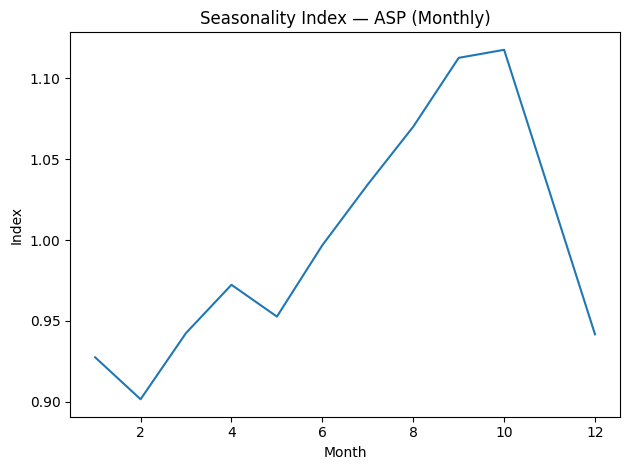

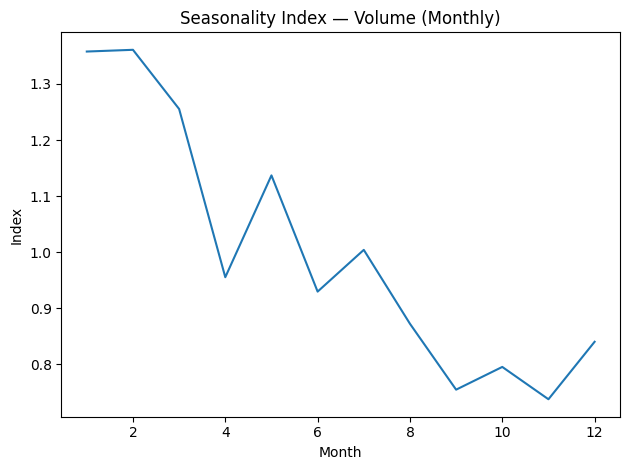

In [23]:

df['month'] = df['date'].dt.month
monthly_nat = df.groupby('month', as_index=False).agg(asp=('averageprice','mean'),
                                                      total_volume=('total_volume','sum'))
seasonality_index_asp = monthly_nat['asp'] / monthly_nat['asp'].mean()
seasonality_index_vol = monthly_nat['total_volume'] / monthly_nat['total_volume'].mean()

print('Seasonality Index (ASP):')
print(seasonality_index_asp.values)
print('Seasonality Index (Volume):')
print(seasonality_index_vol.values)

plt.figure()
plt.plot(monthly_nat['month'], seasonality_index_asp)
plt.title('Seasonality Index — ASP (Monthly)')
plt.xlabel('Month')
plt.ylabel('Index')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(monthly_nat['month'], seasonality_index_vol)
plt.title('Seasonality Index — Volume (Monthly)')
plt.xlabel('Month')
plt.ylabel('Index')
plt.tight_layout()
plt.show()


## Exploratory Price Elasticity

Estimate elasticity by regressing log(Volume) on log(Price) with month and region fixed effects (simplified). Elasticity ≈ coefficient on log price.


In [24]:

# import statsmodels.api as sm

# # Prepare panel-like data
# panel = df.copy()
# panel['log_volume'] = np.log1p(panel['total_volume'])
# panel['log_price'] = np.log(panel['averageprice'].clip(lower=1e-6))

# # Create dummies for region and month
# region_d = pd.get_dummies(panel['region'], drop_first=True)
# month_d = pd.get_dummies(panel['month'], prefix='m', drop_first=True)

# X = pd.concat([panel[['log_price']], region_d, month_d], axis=1)
# X = sm.add_constant(X)
# y = panel['log_volume']

# model = sm.OLS(y, X).fit()
# print(model.summary())

# elasticity = model.params.get('log_price', np.nan)
# print(f"Approx. Price Elasticity (national w/ region+month controls): {elasticity:.3f}")




import statsmodels.api as sm

panel = df.copy()
panel['date'] = pd.to_datetime(panel['date'])
panel['month'] = panel['date'].dt.month

panel['log_volume'] = np.log1p(panel['total_volume'])
panel['log_price']  = np.log(panel['averageprice'].clip(lower=1e-6))

# get_dummies with numeric dtype
region_d = pd.get_dummies(panel['region'], drop_first=True, dtype=float)
month_d  = pd.get_dummies(panel['month'],  prefix='m', drop_first=True, dtype=float)

X = pd.concat([panel[['log_price']], region_d, month_d], axis=1)

# Coerce to numeric and drop rows with NA/inf in X or y
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(panel['log_volume'], errors='coerce')

mask = np.isfinite(X.to_numpy()).all(axis=1) & np.isfinite(y.to_numpy())
X = X.loc[mask]
y = y.loc[mask]

# Add constant after filtering
X = sm.add_constant(X, has_constant='add')

model = sm.OLS(y, X).fit()
print(model.summary())

elasticity = model.params.get('log_price', np.nan)
print(f"Approx. Price Elasticity (national w/ region+month controls): {elasticity:.3f}")


                            OLS Regression Results                            
Dep. Variable:             log_volume   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     675.1
Date:                Mon, 15 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:11:27   Log-Likelihood:                -29839.
No. Observations:               18249   AIC:                         5.981e+04
Df Residuals:                   18183   BIC:                         6.033e+04
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  11.5145    